<h1 style="text-align:center">X-Ray Pneumonia Classifing</h1>

## Preporcessing

### Imports and set up one seed for all

In [1]:
import os
import copy
import torch
import random
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.datasets as datasets 
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from PIL import Image

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)

seed = 42
set_seed(seed)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

In [2]:
# First try of preparing the data

# path_train_normal = 'chest_xray/train/NORMAL/'
# path_train_pneumonia = 'chest_xray/train/PNEUMONIA/'
# path_test_normal = 'chest_xray/test/NORMAL/'
# path_test_pneumonia = 'chest_xray/test/PNEUMONIA/'

# pil_train = []
# y_train = []

# pil_test = []
# y_test = []


# for file in os.listdir(path_train_normal):
#     img = copy.deepcopy(Image.open(path_train_normal + file))
#     y_train.append(0)
#     pil_train.append(img)
    
# for file in os.listdir(path_train_pneumonia):
#     img = copy.deepcopy(Image.open(path_train_pneumonia + file))
#     y_train.append(1)
#     pil_train.append(img)
    
# for file in os.listdir(path_test_normal):
#     img = copy.deepcopy(Image.open(path_test_normal + file))
#     y_test.append(0)
#     pil_test.append(img)
    
# for file in os.listdir(path_test_pneumonia):
#     img = copy.deepcopy(Image.open(path_test_pneumonia + file))
#     y_test.append(1)
#     pil_test.append(img)

# np.array(pil_train[0]).shape

### Class for load images

In [3]:
class XRayImage(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target

### Transforming images

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=299, scale=(0.8, 1.0)),
#     transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
#     transforms.CenterCrop(224),
#    transforms.Grayscale(),
#     transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
#    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = XRayImage('chest_xray/train', transform=train_transforms)
val_dataset = XRayImage('chest_xray/val', transform=test_transforms)
test_dataset = XRayImage('chest_xray/test', transform=test_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train_dataset.targets), train_dataset.targets)

/home/mzillag/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
# for batch_idx, (data, labels) in enumerate(train_dataloader):
#     data, labels = data.to(device), labels.to(device)
#     print(labels[12])
#     plt.imshow(data[12].cpu().permute(1, 2, 0).numpy(), cmap='gray')
#     break

### Checking if image rotations is needed

In [6]:
# plt.figure(figsize=(20, 12))
# for i in range(0, 10):
#     plt.subplot(2, 5, i+1)
#     for batch_idx, (data, labels) in enumerate(train_dataloader):
#         image = data[0]
#         dic = {0:'NORMAL', 1:'PNEUMONIA'}
#         plt.title(dic.get(labels.cpu().numpy()[0]))
#         plt.axis('off')
#         plt.imshow(np.squeeze(image.cpu().numpy()),cmap='gray',interpolation='nearest')
# #         plt.imshow(np.squeeze(image.cpu().permute(1, 2, 0).numpy()),cmap='gray',interpolation='nearest')
#         break

# plt.tight_layout()
# plt.show()

## InceptionV3 training

### Load pretrained model

In [7]:
from torchsummary import summary

num_classes = 2
feature_extract = True

model = models.inception_v3(pretrained=True)
# summary(model.cuda(), (3, 500, 500))

In [8]:
# for param in model.parameters():
#     param.requires_grad = False

model.aux_logits=False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

### Training

#### Accuracy function

In [9]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    
    return float(num_correct)/float(num_samples)*100

#### Training

In [10]:
num_epochs = 15

# criterion = nn.CrossEntropyLoss(weight = torch.Tensor(weights).to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2, verbose=True)

train_accuracy = []
val_accuracy = []
test_accuracy = []
epochs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (data, targets) in enumerate(train_dataloader):
        # Get data to cuda if possible
        data = data.to(device=device)
#         targets = torch.tensor(targets.unsqueeze(1).numpy(), dtype=torch.float32)
        targets = targets.to(device=device)
        
        # forward
        scores = model(data)
#         print(scores.shape, targets.shape)
        loss = criterion(scores, targets)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent or adam step
        optimizer.step()
#         if (batch_idx+1) % 50 == 0:
#             print(batch_idx+1)
#             print(check_accuracy(train_dataloader, model))
    scheduler.step(loss)
    
    train_accuracy.append(check_accuracy(train_dataloader, model))
    val_accuracy.append(check_accuracy(val_dataloader, model))
    test_accuracy.append(check_accuracy(test_dataloader, model))
    epochs.append(epoch+1)
    print(f'Train accuracy:{train_accuracy[epoch]}, validation accuracy:{val_accuracy[epoch]}, test accuracy:{test_accuracy[epoch]}')
    
    model.train()

Epoch 1/15
Train accuracy:92.19708588957054, validation accuracy:68.75, test accuracy:88.78205128205127
Epoch 2/15
Train accuracy:98.25536809815951, validation accuracy:100.0, test accuracy:86.53846153846155
Epoch 3/15
Train accuracy:95.68634969325154, validation accuracy:62.5, test accuracy:80.12820512820514
Epoch 4/15
Train accuracy:97.27760736196319, validation accuracy:62.5, test accuracy:83.33333333333334
Epoch 5/15
Train accuracy:97.62269938650306, validation accuracy:75.0, test accuracy:87.01923076923077
Epoch 6/15
Train accuracy:98.35122699386503, validation accuracy:93.75, test accuracy:85.25641025641025
Epoch 7/15
Train accuracy:98.75383435582822, validation accuracy:100.0, test accuracy:88.30128205128204
Epoch 8/15
Train accuracy:97.23926380368098, validation accuracy:93.75, test accuracy:88.78205128205127
Epoch 9/15
Train accuracy:98.35122699386503, validation accuracy:93.75, test accuracy:87.98076923076923
Epoch 10/15
Train accuracy:98.83052147239265, validation accuracy:9

### Accuracy change visualization

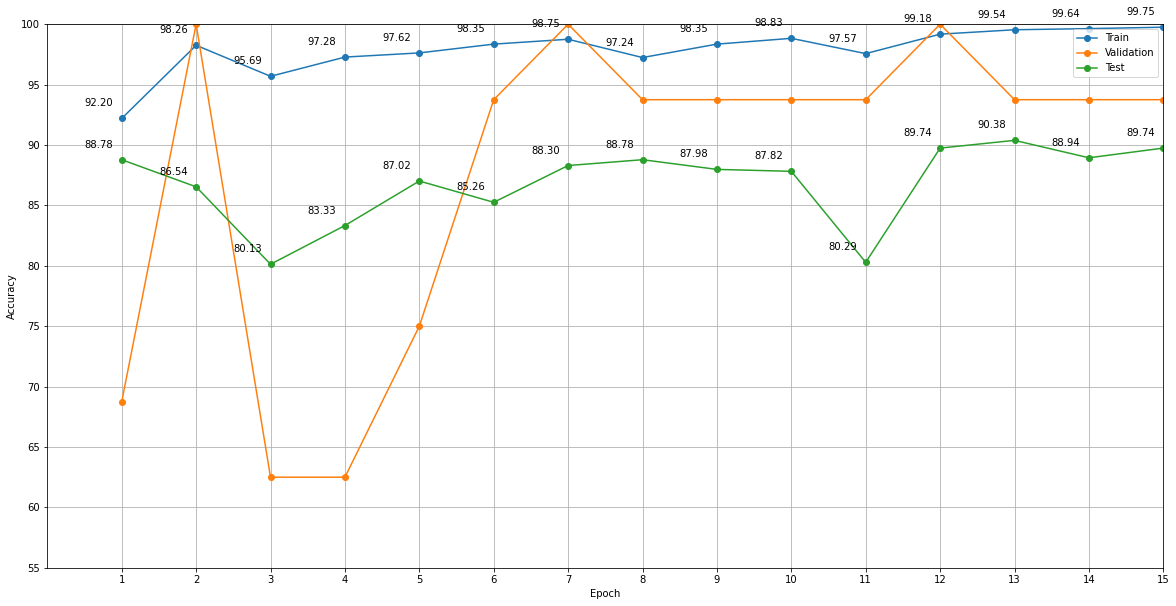

In [11]:
plt.figure(figsize=(20, 10))
plt.axis([0, num_epochs, 55, 100])
plt.xticks(epochs)
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, train_accuracy, '-o', label='Train')
plt.plot(epochs, val_accuracy, '-o', label='Validation')
plt.plot(epochs, test_accuracy, '-o', label='Test')
for i in range(len(epochs)):
    plt.text(i+0.5, train_accuracy[i]+1, f'{train_accuracy[i]:.02f}')
  # plt.text(i+0.5, val_accuracy[i]+1, f'{val_accuracy[i]:.02f}')
    plt.text(i+0.5, test_accuracy[i]+1, f'{test_accuracy[i]:.02f}')
plt.legend()

### Save model

In [12]:
model_save_name = 'inceptionv3.pt'
path = f"saved_models/{model_save_name}" 
torch.save(model.state_dict(), path)